In [35]:
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import PIL
import math
from bpemb import BPEmb

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_PATH = './data/'

seed = 42

torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True


def _init_fn(worker_id):
    np.random.seed(int(seed))

In [37]:
device

'cuda'

In [38]:
class MultiModalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim=1, bias=True):
        super(MultiModalLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        if torch.cuda.is_available():
            self.lstm = nn.LSTMCell(input_dim, hidden_dim).cuda()
        else:
            self.lstm = nn.LSTMCell(input_dim, hidden_dim)
            
    
    
    def forward(self, x, img_context):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            hn = Variable(torch.zeros(x.size(0), self.hidden_dim).cuda())
        else:
            hn = Variable(torch.zeros(x.size(0), self.hidden_dim))

        # Initialize cell state
        if torch.cuda.is_available():
            cn = Variable(torch.zeros(x.size(0), self.hidden_dim).cuda())
        else:
            cn = Variable(torch.zeros( x.size(0), hidden_dim))
            
        if torch.cuda.is_available():
            M = Variable(torch.nn.init.uniform_(
                torch.empty((img_context.size(1), self.hidden_dim),  dtype=torch.float), 
                a = -math.sqrt(1/self.hidden_dim), 
                b = math.sqrt(1/self.hidden_dim)).cuda())
        else:
            M = Variable(torch.nn.init.uniform_(
                torch.empty((img_context.size(1), self.hidden_dim),  dtype=torch.float), 
                a = -math.sqrt(1/self.hidden_dim), 
                b = math.sqrt(1/self.hidden_dim)))

                    
       
        outs = []
        for seq in range(x.size(1)):
            d = torch.matmul(img_context, M)
            hn = hn * d
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
            outs.append(hn.clone())
            
    
        if torch.cuda.is_available():
            out = torch.stack(outs).to('cuda')
        else:
            out = torch.stack(outs)
        out = out.permute((1,0,2))
        return out, (hn, cn)
 

In [39]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, maxlen=64, transform=None):
        self.data = df
        self.tokenizer = tokenizer
        if transform == None:
            self.transform = self._transform()
        else:
            self.transform = transform
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        text = self.data.caption.values[index]
        image_path = self.data.image_path[index]
        
        encoded = self.tokenizer.encode(text, self.maxlen)
        
        input_ids = encoded[:-1]
        label_ids = encoded[1:]
        im = PIL.Image.open(image_path)
        image = im.convert('RGB')
        image = self.transform(image)

        return {'input_ids': torch.tensor(input_ids), 
                'label_ids':torch.tensor(label_ids),
                'image': image}
    
    def __len__(self):
        return len(self.data)
    
    def _transform(self):
        transform = torchvision.transforms.Compose([
            # Resize image to 224 x 224 as required by most vision models
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            # Convert PIL image to tensor with image values in [0, 1]
            torchvision.transforms.ToTensor(),

            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        return transform

In [40]:
class MultiBPE:
    def __init__(self, vs=320000, dim=300, add_pad_emb=True):
        self.multibpemb = BPEmb(lang="multi", vs=vs, dim=dim, add_pad_emb=add_pad_emb)
        self.k2i = self.multibpemb.emb.key_to_index
        self.i2k = self.multibpemb.emb.index_to_key
        self._embedding_matrix = self.multibpemb.emb.vectors

    def encode(self, 
               text, 
               padding=True,
               use_eos=True,
               maxlen=512):
        if use_eos:
            ids = self.multibpemb.encode_ids_with_bos_eos(text)
        else:
            ids = self.multibpemb.encode_ids(text)
        
        seq_len = len(ids)
        
        if seq_len > maxlen:
            ids = ids[:maxlen]  
        
        if padding:
            pad_seq = [self.k2i['<pad>']] * (maxlen-seq_len)
            ids.extend(pad_seq)
        return ids
    
    def decode(self, ids):
        if 320000 in ids:
            id_pad = ids.index(320000)
            ids = ids[:id_pad]
        return self.multibpemb.decode_ids(ids)

    def decode_with_pad(self, ids):
        ret = []
        
        for id_ in ids:
            ret.append(self.i2k[id_])
        
        return ' '.join(ret)
        
    def get_embedding_matrix(self):
        return self._embedding_matrix

In [41]:
multi_bpe = MultiBPE()

In [42]:
def get_dataloader(path=LOAD_PATH, tokenizer=multi_bpe, num_data = 10000):


    df = pd.read_csv(path + 'ml_stacked_data.csv')

    text_df = df[:num_data]

    dataset = ImageCaptionDataset(text_df, tokenizer)

    train_params = {'batch_size': 2,
                    'shuffle': True,
                    'num_workers': 8,
                    'pin_memory':True}

    train_data = torch.utils.data.DataLoader(dataset, drop_last=True, worker_init_fn=_init_fn, **train_params)
    return train_data

In [43]:
train_data = get_dataloader( num_data = 5000)

In [44]:
from torch import nn


class MMLSTM(nn.Module):
    
    def __init__(self, num_features=300, vocab_size=320001, n_hidden=256, n_layers=2, drop_prob=0.1, is_multimodal=True):
        super(MMLSTM, self).__init__()

        self.drop_prob = drop_prob
        self.num_features = num_features
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.vocab_size = vocab_size
        
        ml_matrix = self._load_multilingual_embedding()
        self.emb_layer = nn.Embedding.from_pretrained(ml_matrix)

        ## define the LSTM
        self.lstm = MultiModalLSTM(self.num_features, self.n_hidden)
        
        ## define a dropout layer        
        ## define the fully-connected layer
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.n_hidden, self.vocab_size )  
        
        if is_multimodal:
            self.resnet = self._load_resnet()
    
    def _load_resnet(self):
        resnet50 = torchvision.models.resnet50(pretrained=True)
        resnet50_processed = torch.nn.Sequential(*list(resnet50.children())[:-1])
        for param in resnet50_processed.parameters():
            param.requires_grad = False
        return resnet50_processed
        
    def _load_multilingual_embedding(self):
        matrix = multi_bpe.get_embedding_matrix()
        matrix = torch.tensor(matrix)
        return matrix
    
    
    def forward(self, caption, img):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''

        ## pass input through embedding layer
        embedded = self.emb_layer(caption)     
        
        context_matrix = self.resnet(img)
        context_matrix = context_matrix.view(context_matrix.size(0),
                                            context_matrix.size(1))
        
        ## Get the outputs and the new hidden state from the lstm
        lstm_output, _ = self.lstm(embedded, context_matrix)
        
        ## pass through a dropout layer
        lstm_output = self.dropout(lstm_output)
        ## put "out" through the fully-connected layer
        out = self.fc(lstm_output)

        # return the final output and the hidden state
        return out

In [45]:
multi_lstm = MMLSTM().to(device)

In [46]:
from tqdm import tqdm

def train(ml_model, epochs, train_data, loss_fct, optimizer):
    ml_model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for i, batch in enumerate(tqdm(train_data)):
            text, img, target = batch['input_ids'].to(device), batch['image'].to(device), batch['label_ids'].to(device)
            #print(img.size())
            output = ml_model(text, img)
            ml_model.zero_grad()
            loss = torch.nn.functional.cross_entropy(output.view(-1, 320001), target.view(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(ml_model.parameters(), 1.0)

            optimizer.step()
            epoch_loss += loss.item()
        print(epoch_loss/len(train_data))

In [47]:
optimizer = torch.optim.Adam(multi_lstm.parameters(), lr=5e-4)
loss_fct = torch.nn.CrossEntropyLoss()

In [48]:
#train(multi_lstm, 8, train_data, loss_fct, optimizer)

In [49]:
# torch.save(multi_lstm.state_dict(), './saved_models/bpe-mm_model_50000_mm')

In [50]:
model = MMLSTM().to(device)
model.load_state_dict(torch.load('./saved_models/bpe-mm_model_50000_mm'))
model.eval()

MMLSTM(
  (emb_layer): Embedding(320001, 300)
  (lstm): MultiModalLSTM(
    (lstm): LSTMCell(300, 256)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=320001, bias=True)
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

In [51]:
def process_img(image_path): 
    transform = torchvision.transforms.Compose([
        # Resize image to 224 x 224 as required by most vision models
        torchvision.transforms.Resize(
            size=(224, 224)
        ),
        # Convert PIL image to tensor with image values in [0, 1]
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    im = PIL.Image.open(image_path)
    image = im.convert('RGB')
    image = transform(image)
    
    return image.view(1, image.size(0), image.size(1), image.size(2))

        
    

In [ ]:
# def process_img(image_path): 
#     transform = torchvision.transforms.Compose([
#         # Resize image to 224 x 224 as required by most vision models
#         torchvision.transforms.Resize(
#             size=(224, 224)
#         ),
#         # Convert PIL image to tensor with image values in [0, 1]
#         torchvision.transforms.ToTensor(),

#         torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         )
#     ])
    
#     im = PIL.Image.open(image_path)
#     image = im.convert('RGB')
#     image = transform(image)
    
#     return image.view(1, image.size(0), image.size(1), image.size(2))


In [52]:
def generate_seq_with_img(model, img_path, seed, origin_size, size, temperature=1.0):
    """
    :param model: The complete RNN language model
    :param seed: The first few wordas of the sequence to start generating from
    :param size: The total size of the sequence to generate
    :param temperature: This controls how much we follow the probabilities provided by the network. For t=1.0 we just
        sample directly according to the probabilities. Lower temperatures make the high-probability words more likely
        (providing more likely, but slightly boring sentences) and higher temperatures make the lower probabilities more
        likely (resulting is weirder sentences). For temperature=0.0, the generation is _greedy_, i.e. the word with the
        highest probability is always chosen.
    :return: A list of integers representing a samples sentence
    """

    ls = seed.shape[0]

    tokens = seed.to(device)
    img = process_img(img_path).to(device)
    for i in range(origin_size+1, size):
        probs = model(tokens[None,:], img)

        # Extract the i-th probability vector and sample an index from it
        next_token = sample_logits(probs[0, i-1, :], temperature=temperature)
        
        tokens[i] = next_token

    return tokens

In [53]:
def generate_seq(model, seed, origin_size, size, temperature=1.0):
    """
    :param model: The complete RNN language model
    :param seed: The first few wordas of the sequence to start generating from
    :param size: The total size of the sequence to generate
    :param temperature: This controls how much we follow the probabilities provided by the network. For t=1.0 we just
        sample directly according to the probabilities. Lower temperatures make the high-probability words more likely
        (providing more likely, but slightly boring sentences) and higher temperatures make the lower probabilities more
        likely (resulting is weirder sentences). For temperature=0.0, the generation is _greedy_, i.e. the word with the
        highest probability is always chosen.
    :return: A list of integers representing a samples sentence
    """

    ls = seed.shape[0]

    tokens = seed.to(device)
    
    for i in range(origin_size+1, size):
        probs = model(tokens[None,:])

        # Extract the i-th probability vector and sample an index from it
        next_token = sample_logits(probs[0, i-1, :], temperature=temperature)
        
        tokens[i] = next_token

    return tokens

In [54]:
def sample_logits(preds, temperature=1.0):
    """
    Sample an index from a logit vector.
    :param preds:
    :param temperature:
    :return:
    """

    if temperature == 0.0:
        return torch.argmax(preds)

    preds = preds / temperature
    preds = preds - torch.logsumexp(preds,0)
    
    choice = np.random.choice(len(preds), 1, p=np.exp(preds.detach().cpu().numpy()))
    choice = torch.tensor(choice).to(device)
    return choice

In [55]:
def get_n_samples(model, prompt, n, maxlen=20, temperature=1.0):
    seed = multi_bpe.encode(prompt, maxlen)
    original_size = seed.index(2) - 1
    for i in range(n):
        new_sequence = generate_seq(model, 
                                    seed=torch.tensor(seed), 
                                    origin_size=original_size, 
                                    size=20, 
                                    temperature=temperature)
        print(multi_bpe.decode(new_sequence.tolist()))
        

In [81]:
df = pd.read_csv('./data/' + 'ml_stacked_data.csv')
test_img = './images/black_empty_image.png'

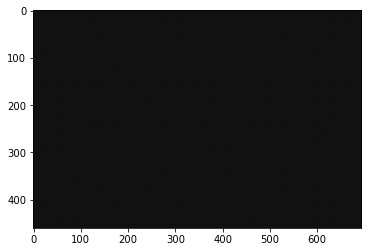

In [82]:
I = plt.imread(test_img)
plt.imshow(I)

In [86]:
get_n_samples_with_img(model, test_img, "the flying avión", n=10, maxlen=40, temperature=0.0)

the flying avión curtainsño de plata blanco, negro y blanca al lado de dos entre ellos
the flying avión de combate de mujer bending into the blocks of an este, eating hay.
the flying avión volando en el aire.
the flying avión con surfistas aparcamiento.
the flying avión están volando y el cielo sobre despegar.
the flying avión de combateing en el espejo
the flying avión aparcado con una gran had hair over a runway
the flying avión y un cielo en el tratando en elgado con una dama de béisbol.
the flying avión se sienta sobre unaos en un estante.
the flying avión filledidos ojos ceracidos y seca de oro


In [87]:
get_n_samples_with_img(model, test_img, "the cat", n=10, maxlen=40, temperature=1.0)

the cat is sitting next to the green cool water .
the cat is is playing a game of soccer
the cat is sitting at a bird in the bowl of adr.
the cat is looking out at the una ventana.
the cat stands on a veryery middle motorcycle on a bun.
the cat is sitting on the counter.
the cat is sitting up and one sign on the grass.
the cat sits in a suitcases while holding a brown teddy bear
the cat sitting on a metal wood outdoor.
the cat is sitting in the middle of a chair.


In [88]:
get_n_samples_with_img(model, test_img, "el amigo", n=10, maxlen=40, temperature=1.0)

el amigo de baño tiene retrete y un lavabo
el amigo de los coches en un piso de madera junto a un paraguas
el amigo de vehículos en un aeropuerto.
el amigo de dos camiones y blancas de un campo de hierba al lado del otro.
el amigo de muffisಶೀಲ and brown beach with umbrellas walking.
el amigo de diferentes relojes se inclina sobre otra muy transitada
el amigo de la cocina tiene un fregadero de hormigón, chair, tomates.
el amigo de la calle tiene una manzana de los esquíes.
el amigo de una habitación está de una cama.
el amigo de un coche está amarilla y cubierta de gran montaña.


In [31]:
#Custom model, no image input
get_n_samples(multi_lstm, "el amigo", n=10, maxlen=40, temperature=1.0)

TypeError: forward() missing 1 required positional argument: 'img'

In [ ]:
#Custom model, no image input
get_n_samples(multi_lstm, "the cat", n=10, maxlen=40, temperature=1.0)

In [ ]:
df = pd.read_csv(LOAD_PATH + 'ml_stacked_data.csv')

text_df = df[:50000]

In [ ]:
len(text_df[text_df.label=='eng'])

In [89]:
###GITHUB!!!!!!!!!!!!!!